# Deep Feature Factorization

Introduced in the paper:<br>
> Edo Collins, Radhakrishna Achanta and Sabine Süsstrunk. _Deep Feature Factorization for Concept Discovery_.  European Conference on Computer Vision (ECCV) 2018.


**DFF** is the application of non-negative matrix faxtorization (NMF) to the ReLU feature activations of a deep neural network. In the case of CNNs trained on images, the resulting factors decompose an image batch into semenatic parts with a high degree of invariance to complex transformations.

The geometry of ReLU activations plays a crucial role in creating favorable conditions for NMF. In particular, the "true" sparsity induced by ReLUs constrains the possible solutions to NMF and makes the factorization problem more well-posed.

The implementation below relies on Pytorch and includes a GPU implementation of NMF with multiplicative updates (Lee and Seung, 2001).

In [1]:
import os, time

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torchvision import models

from nmf import NMF
from utils import imresize, show_heatmaps

In [2]:
# CUDA flag. Speed-up due to CUDA is mostly noticable for large batches.
cuda = True

### Load and pre-process the data

In [3]:
data_path = 'example/gymnast/' # Exmaple data from the iCoseg dataset: http://chenlab.ece.cornell.edu/projects/touch-coseg/
filenames = os.listdir(data_path)

# Load images
raw_images = [plt.imread(os.path.join(data_path, filename)) for filename in filenames]
raw_images = [imresize(img, 224, 224) for img in raw_images] # resize
raw_images = np.stack(raw_images)

# Preprocess
images = raw_images.transpose((0,3,1,2)).astype('float32') # to numpy, NxCxHxW, float32
images -= np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)) # zero mean
images /= np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)) # unit variance

images = torch.from_numpy(images) # convert to Pytorch tensor
if cuda:
    images = images.cuda()

### Load network and extract features

In [4]:
net = models.vgg19(pretrained=True) # load pre-trained VGG-19
if cuda:
    net = net.cuda()
del net.features._modules['36'] # remove max-pooling after final conv layer

In [5]:
with torch.no_grad():
    features = net.features(images)
    flat_features = features.permute(0, 2, 3, 1).contiguous().view((-1, features.size(1))) # NxCxHxW -> (N*H*W)xC

print('Reshaped features from {0}x{1}x{2}x{3} to ({0}*{2}*{3})x{1} = {4}x{1}'.format(*features.shape, flat_features.size(0)))

Reshaped features from 6x512x14x14 to (6*14*14)x512 = 1176x512


### Factorize activations with NMF

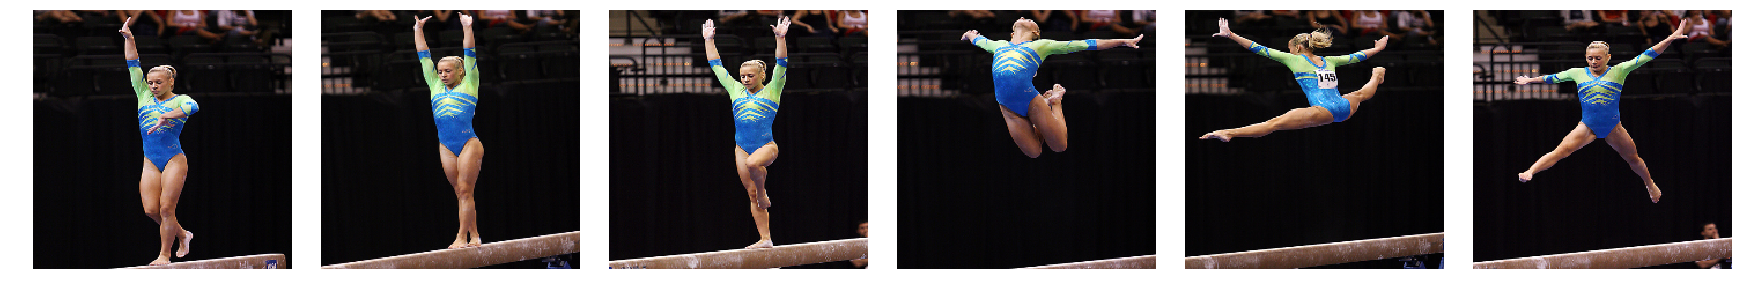

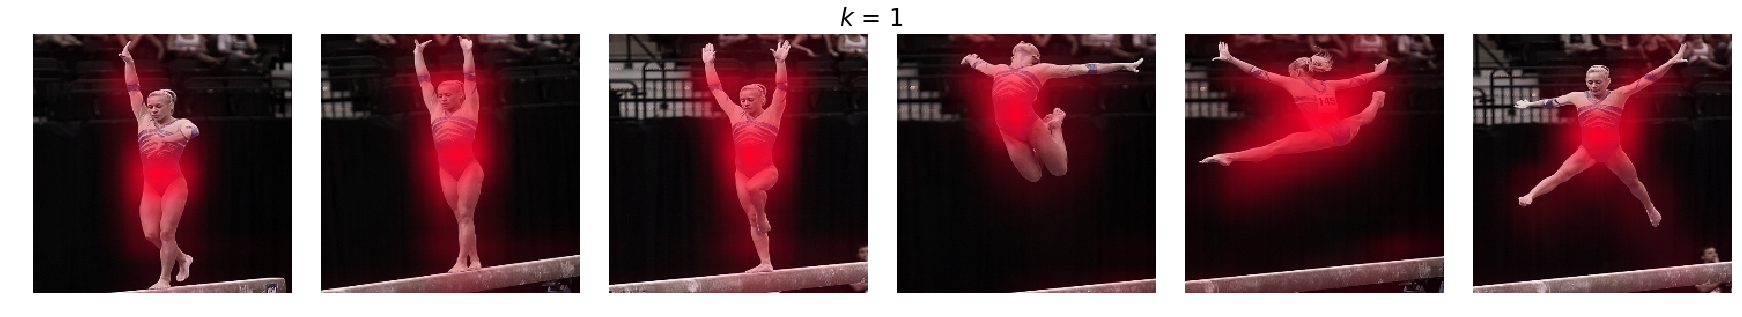

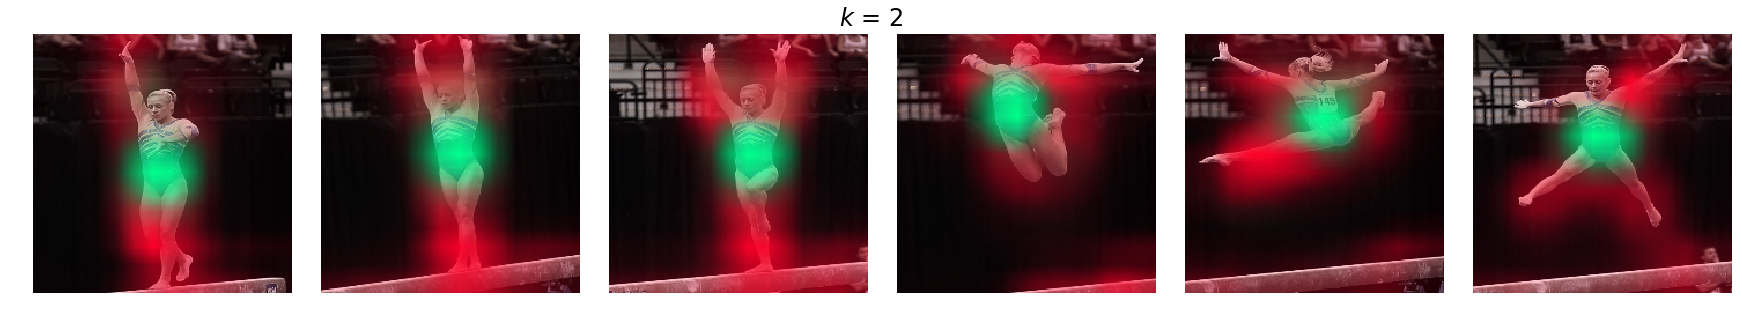

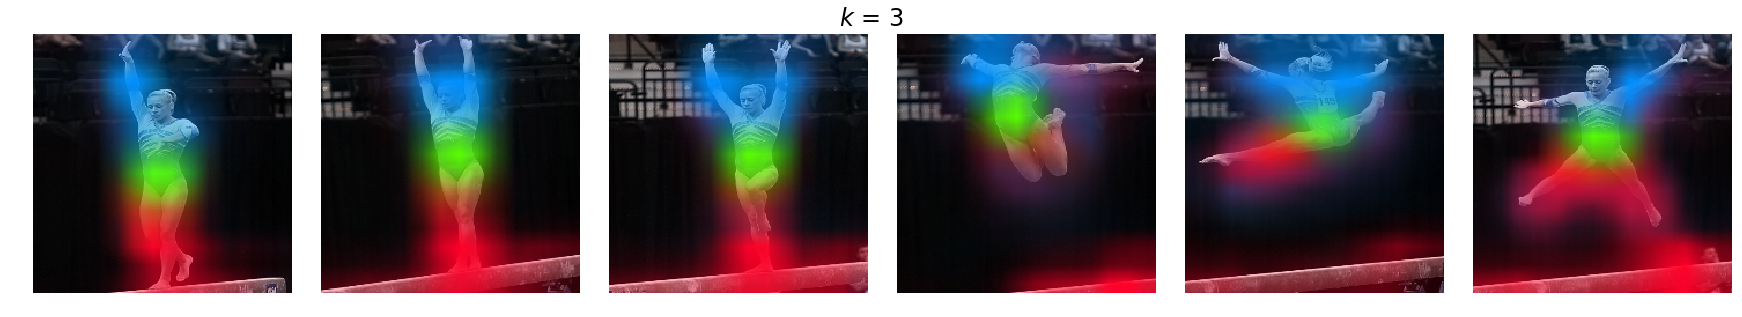

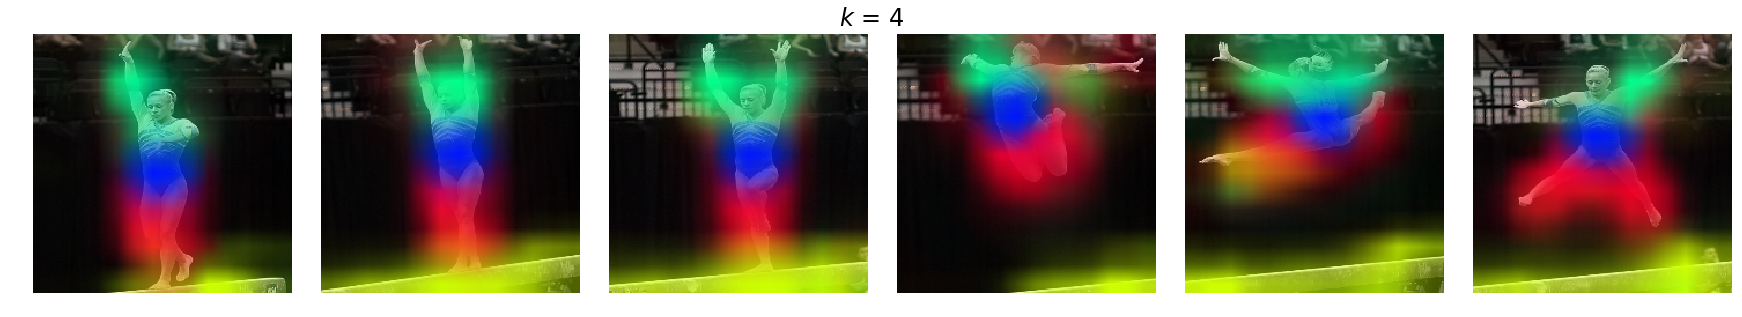

In [6]:

# Show original images
show_heatmaps(raw_images, None, 0, enhance=1)

# Run NMF with K=(1,2,3,4) Note: the permutation of factors is random and is not consistent across iterations
for K in range(1,5):
    with torch.no_grad():
        W, _ = NMF(flat_features, K, random_seed=0, cuda=cuda, max_iter=50)

    heatmaps = W.cpu().view(features.size(0), features.size(2), features.size(3), K).permute(0,3,1,2) # (N*H*W)xK -> NxKxHxW
    heatmaps = torch.nn.functional.interpolate(heatmaps, size=(224, 224), mode='bilinear', align_corners=False) ## 14x14 -> 224x224
    heatmaps /= heatmaps.max(dim=3, keepdim=True)[0].max(dim=2, keepdim=True)[0] # normalize by factor (i.e., 1 of K)
    heatmaps = heatmaps.cpu().numpy()
    
    # Show heat maps
    show_heatmaps(raw_images, heatmaps, K,  title='$k$ = {}'.format(K), enhance=0.3)